In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

## How much data downloaded?

0505 ../data/hls-all-bands/0505 True


/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 485.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 485.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 485.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 485.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/

Text(0.5, 1.0, 'HLS Data downloaded for selected reservoirs')

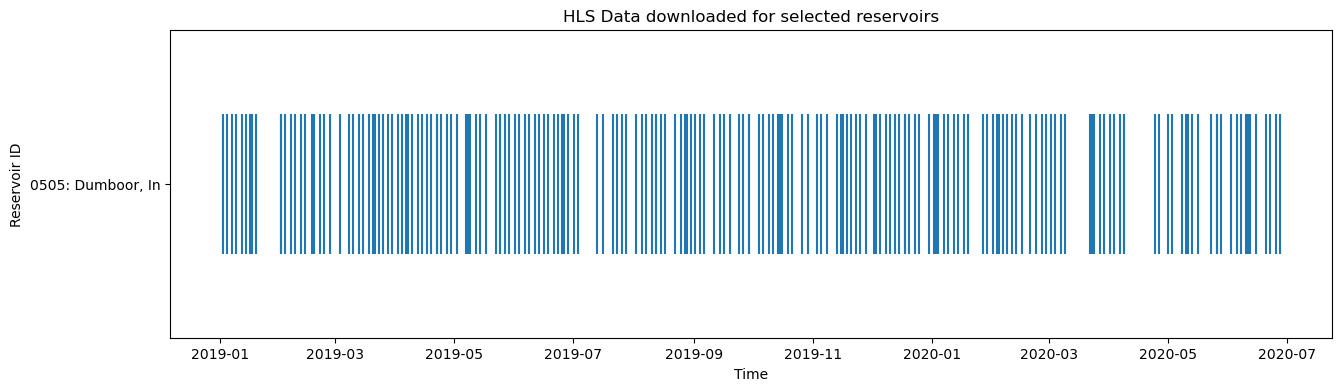

In [15]:
# load
from pathlib import Path
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

hls_save_dir = Path('../data/hls-all-bands')
hls_save_dir.mkdir(exist_ok=True)

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))


selected_reservoirs = [
    '0505', # dumboor. India
    # '0810', # sirindhorn, Thailand.
    # '0830', # Krasoew, Thailand.
    # '0502', # Bhakra dam, India.
    # '0518', # Bhadra, India.
    # '0349', # vaaldam, South Africa.
    # '0464', # Sterkspruit, South Africa.
    # '0214', # Cijara, Spain
    # '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]

res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca'
}



dsses = []
reservoirs = []
available = []
platforms = []
times = []

for reservoir_id in selected_reservoirs:
    fp = hls_save_dir / f'{reservoir_id}'
    reservoir_name = res_names[reservoir_id]
    print(reservoir_id, fp, fp.exists())
    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue

    ds = xr.open_mfdataset(fp.glob("*.nc"), chunks='auto', engine='netcdf4')
    # print(ds)
    dsses.append(ds)
    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(ds.platform.values)
    times.extend(ds.time.values)

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})

ds_dict = {f'{tmsos_id}': ds for tmsos_id, ds in zip(selected_reservoirs, dsses)}
df = pd.merge(df, val_polys[['tmsos_id', 'geometry']], left_on='reservoir', right_on='tmsos_id', suffixes=(False, False))


fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
for i, reservoir_id in enumerate(df.groupby('reservoir').groups):
    data = df.loc[df['reservoir'] == reservoir_id]['time']
    name = res_names[reservoir_id]
    # print(data)
    ax.eventplot(data, orientation='horizontal', linelengths=0.5, lineoffsets=i)
    yticks.append(i)
    ytick_labels.append(f"{reservoir_id}: {name}")

ax.set_yticks(ticks=yticks, labels=ytick_labels)
ax.set_ylabel('Reservoir ID')
ax.set_xlabel('Time')
ax.set_title('HLS Data downloaded for selected reservoirs')

In [16]:
ds_dict['0505']

<xarray.Dataset> Size: 8GB
Dimensions:             (y: 779, x: 650, time: 201)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    spatial_ref         int32 4B 32646
    platform            (time) object 2kB dask.array<chunksize=(201,), meta=np.ndarray>
    eo:cloud_cover_avg  (time) float64 2kB dask.array<chunksize=(201,), meta=np.ndarray>
    reservoir           <U4 16B '0505'
Data variables: (12/20)
    coastal aerosol     (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    blue                (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    nir narrow          (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    ...                  ...
    VAA                 (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    red-edge 1          (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    red-edge 2          (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    red-edge 3          (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    nir broad           (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>
    water vapor         (time, y, x) float32 407MB dask.array<chunksize=(67, 779, 650), meta=np.ndarray>

In [17]:
import hvplot.xarray

ds_dict['0505'].to_dataarray(
    dim = 'band'
).sel(band=['red', 'green', 'blue']).hvplot.rgb(
    x='x', y='y', geo=True, rasterize=True,
    groupby='time',
    bands = 'band',
    # aspect = 1,
    width = 500,
    height = 500, 
).opts(aspect=1, width=400)

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 485.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


BokehModel(combine_events=True, render_bundle={'docs_json': {'64e5ebe4-f1be-495a-81c3-88637761525c': {'version…

## Harmonized Landsat-Sentinel (HLS)

We will use `easysnowdata` to access the HLS data for a single reservoir in the following section.

In [ ]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']=='0810']
dumboor_poly = val_polys.loc[val_polys['tmsos_id']=='0810']

buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
buffered_roi

In [ ]:
dumboor_poly.crs

In [ ]:
hls = easysnowdata.remote_sensing.HLS(
    bbox_input=buffered_roi, start_date="2022-01-01", end_date="2024-03-31"
)
hls

In [ ]:
hls.data

In [ ]:
hls.mask_data()

In [ ]:
hls.get_rgb()
hls.rgb

In [ ]:
f = hls.rgb.plot.imshow(col='time',col_wrap=6,robust=True)

for ax, time, platform in zip(f.axes.flat, hls.rgb.time.values, hls.rgb.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

In [ ]:
hls.get_ndwi()
hls.ndwi

In [ ]:
fig = plt.figure(figsize=(10, 10))

f = hls.ndwi.plot.imshow(col='time',col_wrap=4,robust=True, cmap='RdYlBu', vmax=0.3)

for ax, time, platform in zip(f.axes.flat, hls.ndwi.time.values, hls.ndwi.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('Asia/Kolkata')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

## Download HLS data for 10 reservoirs

Now that we have a way of accessing HLS data, let's download the data locally so that we can use it in our further analysis.

In [ ]:
from pathlib import Path

hls_save_dir = Path('../data/hls')
hls_save_dir.mkdir(exist_ok=True)

Select a few reservoirs, say 10 reservoirs and download their data.

The data will be saved as follows:
```
data/
..hls/
....<res 1 tmsos_id>/
......year 1/
......year 2/
....<res 2 tmsos_id>/
......year 1/
......year 2/
....<res 3 tmsos_id>/
......year 1/
......year 2/
:
```

In [ ]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [ ]:
import easysnowdata
import xarray as xr

def get_hls_id(
        id, 
        start_date="2022-07-01", 
        end_date="2022-07-31", 
        buffer=0.05
    ):
    roi = val_res_poly.loc[val_res_poly['tmsos_id']==id]
    buffered_roi = roi.geometry.iloc[0].convex_hull.buffer(buffer)
    hls = easysnowdata.remote_sensing.HLS(
        bbox_input=buffered_roi, start_date=start_date, end_date=end_date,
        bands=[
            'blue', 'green', 'red', 'nir narrow', 'swir 1', 'swir 2', 'Fmask'
        ]
    )
    hls.mask_data()

    raw_bands = hls.data
    hls.get_ndwi()
    ndwi = hls.ndwi.to_dataset(name='ndwi')

    data = xr.merge([raw_bands, ndwi])

    data = data.assign_coords(
        reservoir=((id))
    )

    # data = data.chunk(chunks={
    #     'time': 30,
    #     'x': 1024,
    #     'y': 1024
    # })

    data = data.drop_vars(['geometry', 'AssociatedBrowseImageUrls'])
    # data['geometry'] = data['geometry'].astype(str)
    # data['AssociatedBrowseImageUrls'] = data['AssociatedBrowseImageUrls'].astype(str)

    return data


In [ ]:
# !rm -r ../data/hls/0810.zarr

In [ ]:
from tqdm.notebook import tqdm
import xarray as xr
import dask

def download_hls_resrvoirs(
        reservoir_ids,
        start_date = "2019-12-01", end_date="2020-03-05",
        buffer_amt = 0.05,
        save_dir = Path('data/'),
        val_poly_fn=Path('data/validation-locations/subset-validation-reservoirs-grand.geojson'),
        dask_client=None
    ):
    save_dir = Path(save_dir)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    delayeds = []

    for reservoir_id in tqdm(reservoir_ids):
        save_fp = save_dir / f"{reservoir_id}.zarr"
        dsses = []
        if save_fp.exists():
            existing_ds = xr.open_zarr(save_fp, consolidated=True)
            existing_start_date = pd.to_datetime(existing_ds.time.isel(time=0).values).round('D')
            existing_end_date = pd.to_datetime(existing_ds.time.isel(time=-1).values).round('D')

            sought_time_period = pd.date_range(start_date, end_date)
            existing_time_period = pd.date_range(existing_start_date, existing_end_date)

            idx_data_required = ~sought_time_period.isin(existing_time_period)

            print("existing", existing_start_date, existing_end_date)
            print("sought", start_date, end_date)
            print("sought period", sought_time_period[idx_data_required])

            data_required = pd.Series(sought_time_period[idx_data_required])
            breaks = data_required[(data_required.diff(1) > pd.Timedelta(1, 'days')) | ((data_required.diff(-1) > pd.Timedelta(1, 'days')))]
            breaks_idx = pd.Index([0]).append(breaks.index)
            idx_ranges = []
            for i, idx in enumerate(breaks_idx[1:]):
                start_idx = breaks_idx[i] if i == 0 else breaks_idx[i] + 1
                idx_ranges.append([start_idx, idx])
            if breaks_idx[-1] != len(data_required)-1:
                idx_ranges.append([breaks_idx[-1], len(data_required)-1])
            dsses.append(existing_ds)
        else:
            data_required = pd.Series(pd.date_range(start_date, end_date))
            idx_ranges = [[0, len(data_required)-1]]

        for idx_range in idx_ranges:
            start_date_subset, end_date_subset = idx_range
            start_date_subset = data_required.iloc[start_date_subset].tz_localize('utc')
            end_date_subset = data_required.iloc[end_date_subset].tz_localize('utc')
            print(f"downloading data for {start_date_subset} to {end_date_subset}")
            hls_data = get_hls_id(
                reservoir_id, 
                start_date_subset, 
                end_date_subset
            )
            dsses.append(hls_data)

        if len(dsses) > 1:
            res_ds = xr.merge(dsses)
        else:
            res_ds = dsses[0]

        res_ds.to_netcdf(save_fp.with_suffix('_new.nc'))
        # if dask_client is not None:
        #     delayeds.append(
        #         res_ds.to_zarr(save_fp, mode='w', compute=False, consolidated=True)
        #     )
        # else:
        #     res_ds.to_zarr(savE_fp, mode='w', compute=True, consolidated=True)
    
    if dask_client is not None:
        dask.compute(*delayeds)

# download_hls_resrvoirs(
#     selected_reservoirs, 
#     start_date = "2019-01-01", end_date="2024-04-30",
#     save_dir=Path('../data/hls/'),
#     dask_client=client
# )

Read locally.

In [ ]:
import humanize
import shutil
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import geopandas as gpd
import easysnowdata
import xarray as xr
import dask


# def download_hls_resrvoirs(
#         reservoir_ids,
#         start_date = "2019-12-01", end_date="2020-03-05",
#         buffer_amt = 0.05,
#         save_dir = Path('../data/hls'),
#         val_poly_fn=Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'),
#         dask_client=None
#     ):
#     save_dir = Path(save_dir)
#     start_date = pd.to_datetime(start_date, utc=False)
#     end_date = pd.to_datetime(end_date, utc=False)
#     assert start_date <= end_date, "start date must be before end date"

#     delayeds = []
#     return_dsses = []
#     existing_ds = None

#     PROCESS = False

#     pbar = tqdm(reservoir_ids)
#     for reservoir_id in pbar:
#         pbar.set_description(f"Reservoir: {reservoir_id}")
#         print(f"Processing {reservoir_id}")
#         try:
#             save_fp = save_dir / f"{reservoir_id}.nc"
#             dsses = []
#             date_ranges = []

#             if save_fp.exists():
#                 existing_ds = xr.open_dataset(save_fp).persist()
#                 dsses.append(existing_ds)
#                 existing_start_date = pd.to_datetime(existing_ds.time.isel(time=0).values).round('D')
#                 existing_end_date = pd.to_datetime(existing_ds.time.isel(time=-1).values).round('D')

#                 sought_time_period = pd.date_range(start_date, end_date)
#                 existing_time_period = pd.date_range(existing_start_date, existing_end_date)

#                 idx_data_required = ~sought_time_period.isin(existing_time_period)

#                 print("existing", existing_start_date, existing_end_date)
#                 print("sought", start_date, end_date)

#                 date_ranges = []
#                 if start_date > existing_start_date and end_date < existing_end_date:
#                     continue
#                 elif end_date < existing_start_date or start_date > existing_end_date:
#                     date_ranges.append(
#                         (start_date, end_date)
#                     )
#                 elif end_date > existing_start_date and end_date < existing_end_date:
#                     date_ranges.append(
#                         (start_date, existing_start_date - pd.Timedelta(1, 'D'))
#                     )
#                 elif start_date > existing_start_date and start_date < existing_end_date:
#                     date_ranges.append(
#                         (existing_end_date + pd.Timedelta(1, 'D'), end_date)
#                     )
#                 elif start_date < existing_start_date and end_date > existing_end_date:
#                     date_ranges.append(
#                         (start_date, existing_start_date - pd.Timedelta(1, 'D'))
#                     )
#                     date_ranges.append(
#                         (existing_end_date + pd.Timedelta(1, 'D'), end_date)
#                     )
                
#                 # check to see if the date ranges are valid. Start date must be smaller than end date.
#                 date_ranges = list(filter(lambda x: x[0] < x[1], date_ranges))
#             else:
#                 date_ranges.append((start_date, end_date))

#             if len(date_ranges) == 0:
#                 print(f"No data to download for {reservoir_id}")
#                 continue
#             print(f"Will download {[f'{start} to {end}' for start, end in date_ranges]} for {reservoir_id}")
#             for subset_start, subset_end in date_ranges:
#                 start_date_subset = subset_start.tz_localize('utc')
#                 end_date_subset = subset_end.tz_localize('utc')
#                 print(f"downloading data for {start_date_subset} to {end_date_subset}")

#                 hls_data = get_hls_id(
#                     reservoir_id, 
#                     start_date_subset, 
#                     end_date_subset
#                 )
#                 if hls_data is not None:
#                     hls_data['platform'] = hls_data['platform'].astype(str)
#                     dsses.append(hls_data)
#                     PROCESS = 1
#             if not PROCESS:
#                 print(f"No new data found for {reservoir_id}")
#                 continue
#             if len(dsses) > 1:
#                 print(*[f"{ds.time.min().values, ds.time.max().values}: {humanize.naturalsize(ds.nbytes)}" for ds in dsses], sep='\n')
#                 res_ds = xr.merge(filter(lambda obj: obj is not None, dsses), compat='override')
#             elif len(dsses) == 1:
#                 res_ds = dsses[0]
#             else:
#                 continue

#             if dask_client is not None:
#                 delayed = res_ds.to_netcdf(save_fp.with_name(f'{reservoir_id}_new.nc'), compute=False)
#                 delayeds.append(delayed)
#             else:
#                 print(f"Saving to {save_fp.with_name(f'{reservoir_id}_new.nc')}")
#                 print(res_ds)
#                 res_ds.to_netcdf(save_fp.with_name(f'{reservoir_id}_new.nc'))

#             with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#                 if dask_client is not None:
#                     print("Computing dask")
#                     print(delayeds)
#                     delayeds = dask.compute(*delayeds)
#                     print("Computed", delayeds)
#                     delayeds = []
#         except Exception as e:
#             print(e)
#             raise e
#         finally:
#             print(save_fp.with_name(f'{reservoir_id}_new.nc').exists())
#             if save_fp.with_name(f'{reservoir_id}_new.nc').exists():
#                 print('opening inspect_ds')
#                 inspect_ds = xr.open_dataset(save_fp.with_name(f'{reservoir_id}_new.nc'))
#                 try:
#                     assert inspect_ds.time.size > 0, f"Dataset for {reservoir_id} is empty"
#                     shutil.move(save_fp.with_name(f'{reservoir_id}_new.nc'), save_fp.with_name(f'{reservoir_id}.nc'))
#                     print(f"Moved {reservoir_id} to {save_fp.with_name(f'{reservoir_id}.nc')}")
#                 except Exception as e:
#                     print(f"Time axis has 0 elements")
#                     pass
#                 inspect_ds.close()


    

data = Path('/tiger1/pdas47/tmsosPP/data')
val_poly_fn = data / 'validation-locations/subset-validation-reservoirs-grand.geojson'
selected_reservoirs = [
    '0505', # dumboor. India
    # '0810', # sirindhorn, Thailand.
    # '0830', # Krasoew, Thailand.
    # '0502', # Bhakra dam, India.
    # '0518', # Bhadra, India.
    # '0349', # vaaldam, South Africa.
    # '0464', # Sterkspruit, South Africa.
    # '0214', # Cijara, Spain
    # '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]



# ds = download_hls_resrvoirs(
#     selected_reservoirs, 
#     start_date="2020-10-01", end_date="2021-09-30",
#     save_dir=Path("/tiger1/pdas47/tmsosPP/data/hls"),
#     val_poly_fn=val_poly_fn,
#     dask_client=None
#     # dask_client=client
# )
# ds
ds = get_hls_id(
    '0505', start_date='2020-07-01', end_date='2020-09-30'
)

# Downloading monthly parallel

In [5]:
from dask.distributed import Client
import dask

dask.config.set(**{'array.slicing.split_large_chunks': True})

client = Client("tcp://localhost:8786")
client

<Client: 'tcp://128.95.29.76:8786' processes=6 threads=6, memory=36.00 GiB>

In [12]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm


hls_save_dir = Path('../data/hls-all-bands')
hls_save_dir.mkdir(exist_ok=True)

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))


selected_reservoirs = [
    '0505', # dumboor. India
    # '0810', # sirindhorn, Thailand.
    # '0830', # Krasoew, Thailand.
    # '0502', # Bhakra dam, India.
    # '0518', # Bhadra, India.
    # '0349', # vaaldam, South Africa.
    # '0464', # Sterkspruit, South Africa.
    # '0214', # Cijara, Spain
    # '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]

res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca'
}


def get_hls_id(
        id, 
        start_date="2022-07-01", 
        end_date="2022-07-31", 
        val_res_poly_fn=Path('/tiger1/pdas47/tmsosPP/data/validation-locations/subset-validation-reservoirs-grand.geojson'),
        buffer=0.05
    ):
    val_res_poly = gpd.read_file(val_res_poly_fn)
    roi = val_res_poly.loc[val_res_poly['tmsos_id']==id]
    buffered_roi = roi.geometry.convex_hull.buffer(buffer)
    hls = easysnowdata.remote_sensing.HLS(
        bbox_input=buffered_roi, start_date=start_date, end_date=end_date, scale_data=False, remove_nodata=False
    )
    data = None
    if hls.data is not None:
        hls.mask_data()

        raw_bands = hls.data
        data = raw_bands
        
        data = data.assign_coords(
            reservoir=((id))
        )

        data = data.drop_vars(['geometry', 'AssociatedBrowseImageUrls'])
    else:
        print(f'No data found between {start_date} and {end_date} for {id}')

    return data


def download_hls_reservoir(
        reservoir_id,
        start_date = "2019-12-01", end_date="2020-03-05",
        buffer_amt = 0.05,
        save_dir = Path('../data/hls'),
        val_poly_fn=Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'),
        dask_client=None
    ):
    save_dir = Path(save_dir)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    print(f"Will download data for {reservoir_id} from {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}")
    date_ranges = pd.date_range(start_date, end_date, freq='1MS', inclusive='both')
    
    download_date_range_args = list(
        zip(date_ranges[:-1], date_ranges[1:] - pd.Timedelta(1, 'days'))
    )

    download_date_range_args.append(
        (date_ranges[-1], pd.to_datetime(end_date))
    )

    dsses = []

    def _get_hls_for_subset(reservoir_id, subset_start, subset_end):
        start_date_subset = subset_start.tz_localize('utc')
        end_date_subset = subset_end.tz_localize('utc')
        save_fp = save_dir / f'{reservoir_id}' / f'{reservoir_id}_{subset_start:%Y-%m-%d}_{subset_end:%Y-%m-%d}.nc'
        save_fp.parent.mkdir(exist_ok=True)

        hls_data = get_hls_id(
            reservoir_id, 
            start_date_subset, 
            end_date_subset
        )
        print(hls_data)
        if hls_data is not None:
            hls_data['platform'] = hls_data['platform'].astype(str)
            hls_data.attrs = dict()
            hls_data.to_netcdf(save_fp)

            return save_fp
        else:
            return False

    if dask_client is not None:
        for subset_start, subset_end in download_date_range_args:
            hls_data = dask_client.submit(_get_hls_for_subset, reservoir_id, subset_start, subset_end, retries=2)
            dsses.append(hls_data)
        
        return_statuses = dask_client.gather(dsses)
    else:
        for subset_start, subset_end in download_date_range_args:
            hls_data = _get_hls_for_subset(reservoir_id, subset_start, subset_end)
            dsses.append(hls_data)

        return_statuses = hls_data
    return return_statuses


pbar = tqdm(total=len(selected_reservoirs))
for reservoir_id in selected_reservoirs:
    pbar.update()
    pbar.set_description(f'Processing {reservoir_id}')
    download_hls_reservoir(
        reservoir_id, start_date = '2019-07-01', end_date = '2019-07-31',
        save_dir='/tiger1/pdas47/tmsosPP/data/hls-all-bands/', dask_client=None
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/1 [00:00<?, ?it/s]

Will download data for 0505 from 2019-07-01 to 2019-07-31


/tmp/ipykernel_3451327/1399391283.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_roi = roi.geometry.convex_hull.buffer(buffer)


Data searched. Access the returned seach with the .search_landsat or .search_sentinel attribute.
No Landsat data found betweem 2019-07-01-2019-07-31.
{'B11': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2019182T042711.v2.0/HLS.S30.T46QCM.2019182T042711.v2.0.B11.tif>, 'B10': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2019182T042711.v2.0/HLS.S30.T46QCM.2019182T042711.v2.0.B10.tif>, 'B02': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2019182T042711.v2.0/HLS.S30.T46QCM.2019182T042711.v2.0.B02.tif>, 'B12': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2019182T042711.v2.0/HLS.S30.T46QCM.2019182T042711.v2.0.B12.tif>, 'SZA': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2019182T042711.v2.0/HLS.S30.T46QCM.2019182T042711.v2.0

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 31.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
client.close()